In [117]:
import pandas as pd
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit


import xgboost as xgb
import catboost as ctb

import sys
import numpy as np
np.random.seed(0)

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import scikitplot as skplt
import numpy as np

import eli5

from scipy.special import boxcox1p
from scipy.special import inv_boxcox1p

from itertools import combinations
from tqdm import tqdm, tqdm_notebook

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, RFE
from sklearn.model_selection import cross_val_score, GroupKFold

import lightgbm as lgb


In [9]:
df_train = pd.read_hdf("../input/energy_train.h5")
df_test = pd.read_hdf("../input/energy_test.h5")

df_train["date"] = pd.to_datetime(df_train["date"], format = '%d/%m/%Y')
df_test["date"] = pd.to_datetime(df_test["date"], format = '%d/%m/%Y')

df_all = pd.concat([df_train, df_test])
df_all["date"] = pd.to_datetime(df_all["date"])

df_all = df_all.set_index('date')
df_all.sort_index(inplace=True)

df_all.shape

(35252, 2)

In [10]:
df_all_agg = df_all.resample('1h').mean()

In [133]:
def simple_feature_engineering(df):
    
    df['day_'] = df_all_agg.index.day
    df['weekday_'] = df_all_agg.index.weekday
    #df["dayofweek"] = df_all_agg.index.dayofweek
    df['week_'] = df_all_agg.index.week
    df['is_month_start'] = df_all_agg.index.is_month_start
    df['is_month_end'] = df_all_agg.index.is_month_end
    df['is_quarter_start'] = df_all_agg.index.is_quarter_start
    df['is_quarter_end'] = df_all_agg.index.is_quarter_end
    df['dayofyear'] = df_all_agg.index.dayofyear
    df['month_'] = df_all_agg.index.month
    df['year_'] = df_all_agg.index.year
    df['quarter_'] = df_all_agg.index.quarter
    df['hour_'] = df_all_agg.index.hour
    df['isWeekend'] = df_all_agg.weekday_.map(lambda x: 1 if (x == 5) |  (x == 6)  else 0)
    df['is_year_start'] = df_all_agg.apply(lambda x: 1 if (x['month_'] == 1) & (x['day_'] == 1) else 0, axis = 1)
    df['is_year_end'] = df_all_agg.index.is_year_end
    df['taryfa_dzien'] = df_all_agg['hour_'].map(lambda x: 1 if ((x >=6) & (x<13)) | ((x >=15) & (x<22)) else 0 )
    df['dark_hour'] = df_all_agg['hour_'].map(lambda x: 1 if (x >=23) & (x<=6) else 0 )
   
    df['dark_hour_day'] = df_all_agg.apply(lambda x: 1 if ((x['hour_'] >= 8) & (x['hour_']<=22)) and  x['weekday_'] in ([0,1,2,3,4])else 0, axis=1 )
    
    df['is_leap_year'] = df_all_agg.index.is_leap_year
    df['days_in_month'] = df_all_agg.index.days_in_month
    
    first_day = df.index.values[0]
    df['days'] = df.index.map(lambda x: (x - first_day).days )
    
    df['wakacje'] = df_all_agg.month_.map(lambda x: 1 if (x == 7) | (x == 8) else 0).astype('int')
    
    df['week_in_month'] = pd.to_numeric(df.index.day/7)
    df['week_in_month'] = df['week_in_month'].apply(lambda x: math.ceil(x))
    
    df['datetime'] = df_all_agg.index.date
    df['datetime'] = pd.to_datetime(df_all_agg['datetime'])
    
    df['trend'] = df_all_agg.year_.map(lambda x: 1 if (x==2018) | (x==2019) else 2 if (x==2020) else 3)
    
    df['najwiekszy_przyrost_week'] = df_all_agg.week_.isin([1])
    df['najwiekszy_przyrost_weekday'] = df_all_agg.weekday_.isin([0])
    df['najwiekszy_spadek_weekday'] = df_all_agg.weekday_.isin([5])
    df['najwiekszy_przyrost_hour'] = df_all_agg.hour_.isin([7,8])
    
    df['hour_5'] = df_all_agg.hour_.isin([5])
    df['hour_2'] = df_all_agg.hour_.isin([2])
    df['hour_4'] = df_all_agg.hour_.isin([4])
    df['hour_23'] = df_all_agg.hour_.isin([23])
    df['hour_0'] = df_all_agg.hour_.isin([0])
    df['hour_1'] = df_all_agg.hour_.isin([1])
    df['hour_3'] = df_all_agg.hour_.isin([3])
    df['hour_6'] = df_all_agg.hour_.isin([6])
    df['hour_7'] = df_all_agg.hour_.isin([7])
    df['hour_8'] = df_all_agg.hour_.isin([8])
    df['hour_9'] = df_all_agg.hour_.isin([9])
    df['hour_10'] = df_all_agg.hour_.isin([10])
    df['hour_11'] = df_all_agg.hour_.isin([11])
    df['hour_12'] = df_all_agg.hour_.isin([12])
    df['hour_13'] = df_all_agg.hour_.isin([13])
    df['hour_14'] = df_all_agg.hour_.isin([14])
    df['hour_15'] = df_all_agg.hour_.isin([15])
    df['hour_16'] = df_all_agg.hour_.isin([16])
    df['hour_17'] = df_all_agg.hour_.isin([17])
    df['hour_18'] = df_all_agg.hour_.isin([18])
    df['hour_19'] = df_all_agg.hour_.isin([19])
    df['hour_20'] = df_all_agg.hour_.isin([20])
    df['hour_21'] = df_all_agg.hour_.isin([21])
    df['hour_22'] = df_all_agg.hour_.isin([22])
    
    df['czas_zimowy'] = df_all_agg.datetime.map(lambda x: 1 if ((x>=pd.to_datetime('2021-10-31').date()) & 
                                                        (x<pd.to_datetime('2022-03-27').date())) | 
    ((x>=pd.to_datetime('2020-10-25').date()) & (x<pd.to_datetime('2021-03-28').date())) | 
    ((x>=pd.to_datetime('2019-10-27').date()) & (x<pd.to_datetime('2020-03-29').date())) | 
    ((x>=pd.to_datetime('2018-10-28').date()) & (x<pd.to_datetime('2019-03-30').date()))
    else 0).astype('int')
    
    df['zmiana_letnia'] = df.datetime.isin(['2019-03-30','2020-03-29','2021-03-28','2022-03-27'])
  
    df['holliday'] = df.datetime.isin([#'2018-12-31','2019-12-31','2020-12-31','2021-12-31' ,
                                       '2018-01-01', 
                                       '2018-01-06', '2018-04-01','2018-04-02','2018-05-01', '2018-05-03', 
                                       '2018-05-20', '2018-05-31', '2018-08-15', '2018-11-01', '2018-11-11',
                                       '2018-12-25', '2018-12-26', '2019-01-01', '2019-01-06', '2019-04-21', 
                                       '2019-04-22', '2019-05-01', '2019-05-03','2019-06-09', '2019-06-20', 
                                       '2019-08-15', '2019-11-01', '2019-11-11', '2019-12-25', '2019-12-26', 
    our_
0.0055	majowka
0.0052	taryfa_dzien
0.0040	hour_6
0.0037	hour_0
0.0035	is_leap_year
0.0035	week_
0.0032	szesciu_kroli
0.0029	swietych
0.0025	dayofyear                                   '2020-01-01', '2020-01-06', '2020-04-12', '2020-04-13', '2020-05-01', 
                                       '2020-05-03', '2020-05-31', '2020-06-11', '2020-08-15','2020-11-01', 
                                       '2020-11-11', '2020-12-25', '2020-12-26', '2021-01-01', '2021-01-06', 
                                       '2021-04-04', '2021-04-05','2021-05-01', '2021-05-03', '2021-05-23', 
                                       '2021-06-03', '2021-08-15', '2021-11-01', '2021-11-11', '2021-12-25',
                                       '2021-12-26', '2022-01-01', '2022-01-06'])
                                   
    
    df['boze_cialo'] = df.datetime.isin(['2018-05-20','2019-06-09','2020-06-11', '2021-06-03'])
    
    df['boze_nar'] = df.datetime.isin(['2018-12-25','2018-12-26','2019-12-25','2019-12-26','2020-12-25','2020-12-26','2021-12-25','2021-12-26'])     
    df['majowka'] = df.datetime.isin(['2018-05-01', '2018-05-02','2018-05-03',  '2019-05-01','2019-05-02', 
                                      '2019-05-03', '2020-05-01','2020-05-02', '2020-05-03', '2021-05-01','2021-05-02', '2021-05-03', '2022-05-01','2022-05-02', '2022-05-03'])
  
    df['wigilia'] = df.datetime.isin(['2018-12-24','2019-12-24','2020-12-24','2021-12-24','2022-12-24'])
    df['szesciu_kroli'] = df.datetime.isin(['2018-01-06','2019-01-06','2020-01-06','2021-01-06','2022-01-06'])
    df['wielkanoc'] = df.datetime.isin(['2018-04-01','2018-04-02',
                                        '2019-04-21','2019-04-22','2020-04-13','2020-04-12',
                                        '2021-04-04','2022-04-05'])
    
    df['swietych'] = df.datetime.isin(['2018-11-01','2019-11-01','2020-11-01','2021-11-01'])
    
    df['11_listopada'] = df.datetime.isin(['2018-11-11','2019-11-11','2020-11-11','2021-11-11'])
    
    df['wielka_sobota'] = df.datetime.isin(['2018-03-31','2019-04-20','2020-04-11','2021-04-03'])
    
    #d5 = df.groupby( ["hour_", 'month_'] ).agg([np.median, np.mean])['value'].reset_index()
    #d5.rename(columns={'median': 'median_df_q5','mean': 'mean_df_q5'}, inplace=True)
    #df = pd.merge(df, d5, on=["hour_", 'month_'], how = 'left')#->dla cat min
    
    #d51 = df.groupby( ["hour_", 'month_', 'week_in_month'] ).agg([np.mean, np.median])['value'].reset_index()
    #d51.rename(columns={'mean': 'mean_df_q51', 'median': 'median_df_q51'}, inplace=True)
    #df = pd.merge(df, d51, on=["hour_", 'month_', 'week_in_month'], how = 'left')#->dla cat min
    
    #d4 = df.groupby( ["hour_", "dayofweek"] ).agg([np.median, np.mean])['value'].reset_index()
    #d4.rename(columns={'median': 'median_df_q4','mean': 'mean_df_q4','size':'size_df_q4'}, inplace=True)
    #df = pd.merge(df, d4, on=["hour_", "dayofweek"], how = 'left')
    
    
    #d4_ = df.groupby( ["hour_", "dayofweek",'month_'] ).agg([np.median, np.mean])['value'].reset_index()
    #d4_.rename(columns={'median': 'median_df_q','mean': 'mean_df_q','size':'size_df_q4'}, inplace=True)
    #df = pd.merge(df, d4_, on=["hour_", "dayofweek",'month_'], how = 'left')
    
    #d41_ = df.groupby( ["hour_", "dayofweek",'month_','quarter_'] ).agg([np.median, np.mean])['value'].reset_index()
    #d41_.rename(columns={'median': 'median_df_q_41','mean': 'mean_df_q_41','size':'size_df_q4'}, inplace=True)
    #df = pd.merge(df, d41_, on=["hour_", "dayofweek",'month_','quarter_'], how = 'left')
   
    #d44 = df.groupby( ["hour_", "dayofweek",'month_'] ).agg([np.median, np.mean])['value'].reset_index()
    #d44.rename(columns={'median': 'median_df_q44','mean': 'mean_df_q44','size':'size_df_q4'}, inplace=True)
    #df = pd.merge(df, d44, on=["hour_", "dayofweek",'month_'], how = 'left')
    
    #per_99=np.percentile(df_train['value'], 99)
    #df['perc_99'] = df.value.map(lambda x: 1 if x>= per_99 else 0)
    
    df['luty_2_2021'] = df.apply(lambda x: 1 if (x['year_']==2021) & (x['week_in_month']==2) & 
                                           (x['month_']==2) else 0, axis = 1)
    

    #medians = df.groupby( ['year_', 'month_','weekday_'] ).agg([np.median, np.mean])['value'].reset_index()
    #medians.rename(columns={'median': 'median_df_m_y_w','mean': 'mean_df_m_y_w'}, inplace=True)
    #df = pd.merge(df, medians, on=['weekday_','month_','year_'], how = 'left')
    
    #d2 = df.groupby( ['weekday_','is_quarter_start','quarter_','hour_','trend'] ).agg([np.median, np.mean])['value'].reset_index()
    #d2.rename(columns={'median': 'median_df_q2','mean': 'mean_df_q2'}, inplace=True)
    #df = pd.merge(df, d2, on=['weekday_','is_quarter_start','quarter_','hour_','trend'], how = 'left')
    
    #d3 = df.groupby( ['weekday_','quarter_','hour_','trend'] ).agg([np.median, np.mean])['value'].reset_index()
    #d3.rename(columns={'median': 'median_df_q3','mean': 'mean_df_q3'}, inplace=True)
    #df = pd.merge(df, d3, on=['weekday_','quarter_','hour_','trend'], how = 'left')
    
    #d4 = df.groupby( ["hour_", "dayofweek"] ).agg([np.median, np.mean])['value'].reset_index()
    #d4.rename(columns={'median': 'median_df_q4','mean': 'mean_df_q4','size':'size_df_q4'}, inplace=True)
    #df = pd.merge(df, d4, on=["hour_", "dayofweek"], how = 'left')
    
    #d5 = df.groupby( ["hour_", 'month_'] ).agg([np.median, np.mean,smooth_mean(20)])['value'].reset_index()
    #d5.rename(columns={'median': 'median_df_q5','mean': 'mean_df_q5','smooth_mean()': 'sm_mean'}, inplace=True)
    #df = pd.merge(df, d5, on=["hour_", 'month_'], how = 'left')#->dla cat min
    
    #d10 = df.groupby( ["hour_", 'month_','dayofweek'] ).agg([np.median, np.mean])['value'].reset_index()
    #d10.rename(columns={'median': 'median_df_q10','mean': 'mean_df_q10'}, inplace=True)
    #df = pd.merge(df, d10, on=["hour_", 'month_','dayofweek'], how = 'left')#->dla cat min
    
    #d8 = df.groupby(  ["hour_", "dayofweek", "month_",'year_']).agg([np.median, np.mean])['value'].reset_index()
    #d8.rename(columns={'median': 'median_df_q8','mean': 'mean_df_q8'}, inplace=True)
    #df = pd.merge(df, d8, on= ["hour_", "dayofweek", "month_",'year_'], how = 'left')
    
    #d9 = df.groupby(  ["hour_", "dayofweek", "month_",'year_']).agg([np.median, np.mean])['value'].reset_index()
    #d9.rename(columns={'median': 'median_df_q8','mean': 'mean_df_q8'}, inplace=True)
    #d9 = pd.merge(df, d8, on= ["hour_", "dayofweek", "month_",'year_'], how = 'left')
    
    #d6 = df.groupby( ["hour_", "dayofweek", "month_"] ).agg([np.median, np.mean])['value'].reset_index()
    #d6.rename(columns={'median': 'median_df_q6','mean': 'mean_df_q6'#,'min': 'min_df_q6','std': 'std_df_q6'
    #                  }, inplace=True)
    #df = pd.merge(df, d6, on=["hour_", "dayofweek", "month_"], how = 'left')
    
    #df_w_q_h_iy = df_train.groupby(['weekday_','is_year_start','quarter_','hour_']).agg(["mean",smooth_mean()])["value"].reset_index()
    #df_w_q_h_iy.rename(columns= { 
    #                            'mean': 'mean_w_q_h_iy',
    #'smooth_mean': 'mean_smooth_w_q_h_iy' },
    #                  inplace = True
    #                 )
    
    #d7 = df.groupby( ["hour_", "dayofweek", "month_",'trend'] ).agg([np.median, np.mean])['value'].reset_index()
    #d7.rename(columns={'median': 'median_df_q7','mean': 'mean_df_q7'}, inplace=True)
    #df = pd.merge(df, d7, on=["hour_", "dayofweek", "month_",'trend'], how = 'left')
    
                                                        
    #df_m_y_w = df.groupby(['year_', 'month_','week_','weekday_']).agg([np.median, np.mean])["value"].reset_index()
    
    #df_m_y_w.rename(columns= { 'median': 'median_df_m_y_w','mean': 'median_df_m_y_w'},inplace = True) 
    
    #df = pd.merge(df, df_m_y_w, on = ['year_', 'month_','week_','weekday_'], how = 'left')
      
    #df['median_df_m_y_w'].fillna(method='bfill', inplace=True)
    
    #get value from yesterday 
    #d = 1
    #df_train_new = df.copy()
    #feat_name = "dayofyear_{}d".format(d)
    #value_feat_name = "value_{}dayofyear".format(d)

    #df_train_new[feat_name] = df_train_new["dayofyear"] + d
    #df_train_new.rename(columns={"value": value_feat_name}, inplace=True)

    #df = pd.merge(df, df_train_new[ [value_feat_name, feat_name, "year_", "hour_"] ], left_on=["year_", "dayofyear", "hour_"], right_on=["year_", feat_name, "hour_"], how="left")
    
    #d = 7
    #df_train_new = df.copy()
    #feat_name = "dayofyear_{}d".format(d)
    #value_feat_name = "value_{}dayofyear".format(d)

    #df_train_new[feat_name] = df_train_new["dayofyear"] + d
    #df_train_new.rename(columns={"value": value_feat_name}, inplace=True)

    #df = pd.merge(df, df_train_new[ [value_feat_name, feat_name, "year_", "hour_"] ], left_on=["year_", "dayofyear", "hour_"], right_on=["year_", feat_name, "hour_"], how="left")

    return df

df_all_prep = simple_feature_engineering(df_all_agg)

In [ ]:
#df_all_prep['pelny_lockdown'] = df_all_prep.datetime.map(lambda x: 1 if (x>=pd.to_datetime('2020-03-24').date()) & 
#                                                        (x<pd.to_datetime('2020-04-12').date()) else 0)
     
#df_all_prep['zamkniecie_szkol'] = df_all_prep.datetime.map(lambda x: 1 if (x>=pd.to_datetime('2020-03-12').date()) & 
#                                                        (x<pd.to_datetime('2020-05-24').date()) else 0 )
#df_all_prep['zamkniecie_szkol_2'] = df_all_prep.datetime.map(lambda x: 1 if (x>=pd.to_datetime('2020-10-23').date()) & 
#                                                        (x<pd.to_datetime('2020-11-09').date()) else 0 )

In [ ]:
#df_all_prep['lock_marzec'] = df_all_prep.apply(lambda x: 1 if x['year_'] == 2020 & ((x['month_'] == 3) | x['month_'] == 4 | x['month_'] == 5)
#                                               else 0, axis=1)

In [134]:
df_all_prep['value_shift_24'] =  df_all_prep['value'].shift(24)
df_all_prep['value_shift_168'] =  df_all_prep['value'].shift(168)

In [135]:
df_all_prep['coalesce_shift'] = df_all_prep.apply(lambda x: x['value_shift_168']  if (x['weekday_'] == 0) | (x['weekday_'] == 5) else x['value_shift_24'] , axis=1)

In [136]:
df_all_prep['coalesce_24'] = df_all_prep[['value', 'value_shift_24', 'value_shift_168']].bfill(axis=1).iloc[:, 0]
df_all_prep['coalesce_168'] = df_all_prep[['value', 'value_shift_168', 'value_shift_24']].bfill(axis=1).iloc[:, 0]

In [137]:
df_all_prep['coalesce_total'] = df_all_prep.apply(lambda x: x['coalesce_168']  if (x['weekday_'] == 0) | (x['weekday_'] == 5) else x['coalesce_24'] , axis=1)

In [ ]:
#df_all_prep['cola_diff'] = df_all_prep['coalesce_shift'].diff()

In [ ]:
#df_all_prep['value_rolling_2tyg_mean'] = df_all_prep['value_shift_24'].rolling(336).mean()
#df_all_prep['value_rolling_2tyg_median'] = df_all_prep['value_shift_24'].rolling(336).median()
#df_all_prep['value_rolling_2tyg_mean_168'] = df_all_prep['value_shift_168'].rolling(336).mean()
#df_all_prep['value_rolling_2tyg_median_168'] = df_all_prep['value_shift_168'].rolling(336).median()
#df_all_prep['value_rolling_1tyg_mean_24'] = df_all_prep['value_shift_24'].rolling(168).mean()
#df_all_prep['value_rolling_1tyg_median_24'] = df_all_prep['value_shift_24'].rolling(168).median()
#df_all_prep['value_rolling_1tyg_std_24'] = df_all_prep['value_shift_24'].rolling(168).std()
#df_all_prep['value_rolling_1tyg_max_24'] = df_all_prep['value_shift_24'].rolling(168).min()
#df_all_prep['value_rolling_1tyg_min_24'] = df_all_prep['value_shift_24'].rolling(168).max()
#df_all_prep['value_rolling_1tyg_diff'] = df_all_prep['value_shift_24'].diff()


In [ ]:
#df_all_prep['value_rolling_1tyg_mean_168'] = df_all_prep['value_shift_168'].rolling(168).mean()
#df_all_prep['value_rolling_1tyg_median_168'] = df_all_prep['value_shift_168'].rolling(168).median()
#df_all_prep['value_rolling_1tyg_std_168'] = df_all_prep['value_shift_168'].rolling(168).std()
#df_all_prep['value_rolling_1tyg_max_168'] = df_all_prep['value_shift_168'].rolling(168).min()
#df_all_prep['value_rolling_1tyg_min_168'] = df_all_prep['value_shift_168'].rolling(168).max()

#df_all_prep['value_rolling_1tyg_diff_24'] = df_all_prep['value_shift_24'].diff()

#df_all_prep['value_rolling_1tyg_diff_168'] = df_all_prep['value_shift_168'].diff()

## EDA

In [124]:
train_prep = df_all_prep[ df_all_prep["value"].notnull()]
train_prep['pct_change'] = train_prep['value'].pct_change().mul(100)

<ipython-input-124-303ac1e58127>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_prep['pct_change'] = train_prep['value'].pct_change().mul(100)


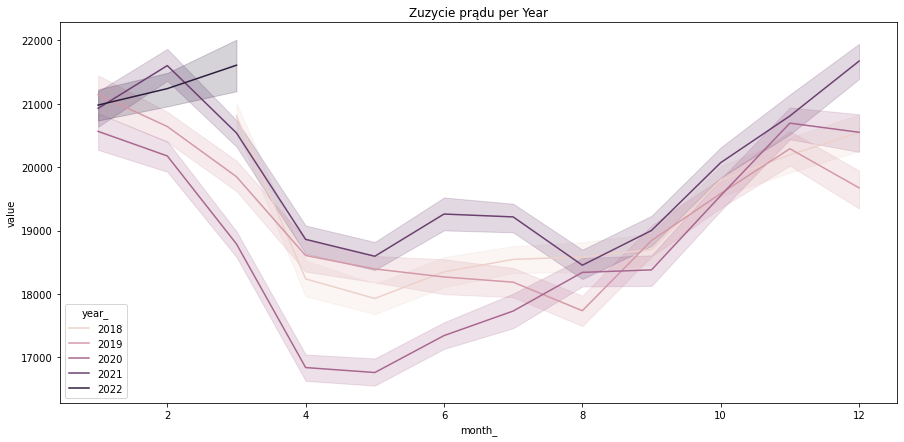

In [125]:
plt.figure(figsize=(15,7))
sns.lineplot(x="month_", y="value", hue="year_", data=train_prep)
plt.title('Zuzycie prądu per Year');

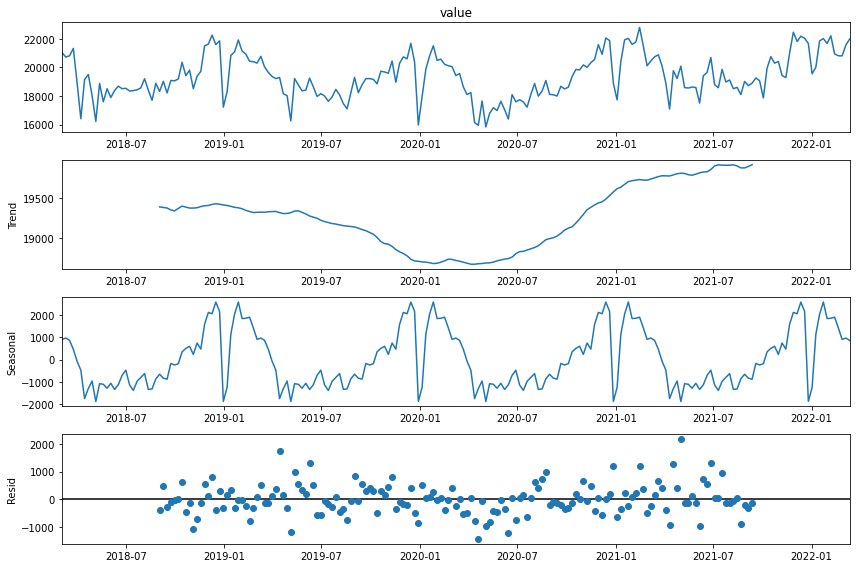

In [126]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12, 8
df_0_1m = df_all.resample('1W').mean()
decomposition = sm.tsa.seasonal_decompose(df_0_1m.value, model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

Text(0.5, 1.0, 'Predykcja wgg metody naiwnej')

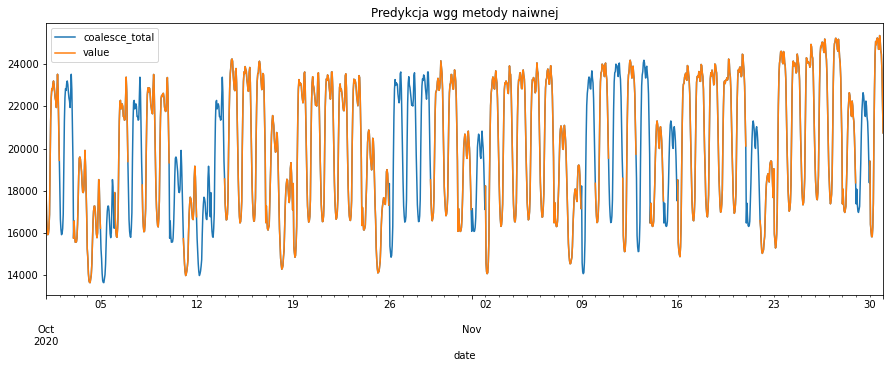

In [139]:
df_all_prep[((df_all_prep['year_']==2020) & (df_all_prep['month_']== 10))|((df_all_prep['year_']==2020) & (df_all_prep['month_'] == 11))][['coalesce_total','value']].plot(figsize=(15,5))
plt.title('Predykcja wg metody naiwnej')

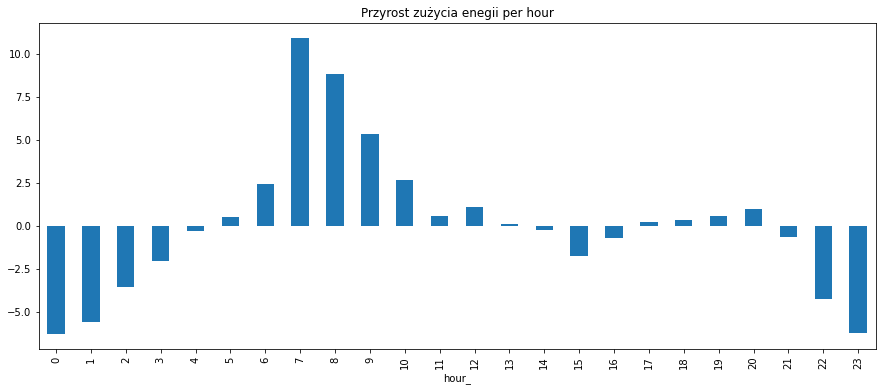

In [127]:
plt.figure(figsize=(15,6))
#train_prep['pct_change'] = train_prep['value'].pct_change().mul(100)
train_prep.groupby(['hour_']).agg(np.mean)['pct_change'].plot(kind='bar')
plt.title('Przyrost zużycia enegii per hour');

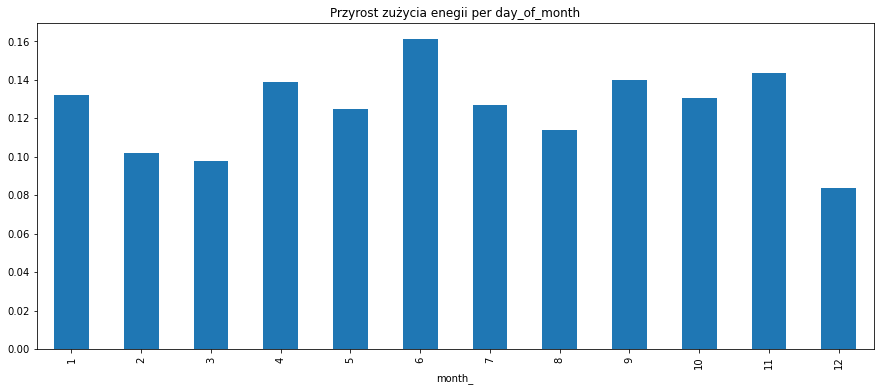

In [130]:
plt.figure(figsize=(15,6))
train_prep.groupby(['month_']).agg(np.mean)['pct_change'].plot(kind='bar')
plt.title('Przyrost zużycia enegii per day_of_month');

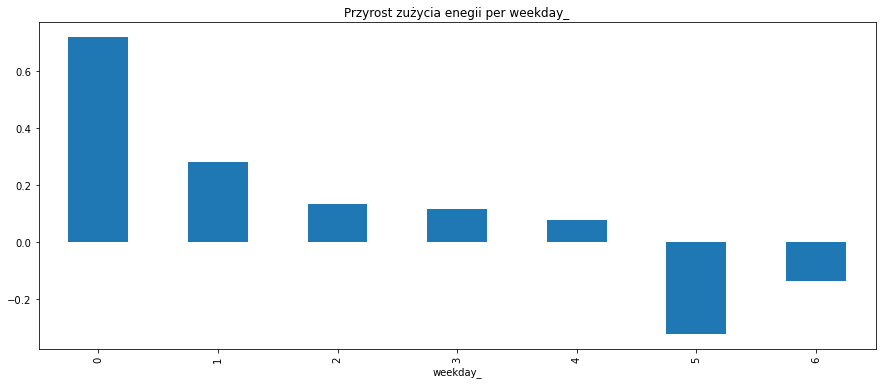

In [53]:
plt.figure(figsize=(15,6))
train_prep.groupby(['weekday_']).agg(np.mean)['pct_change'].plot(kind='bar')
plt.title('Przyrost zużycia enegii per weekday_');

25740.534


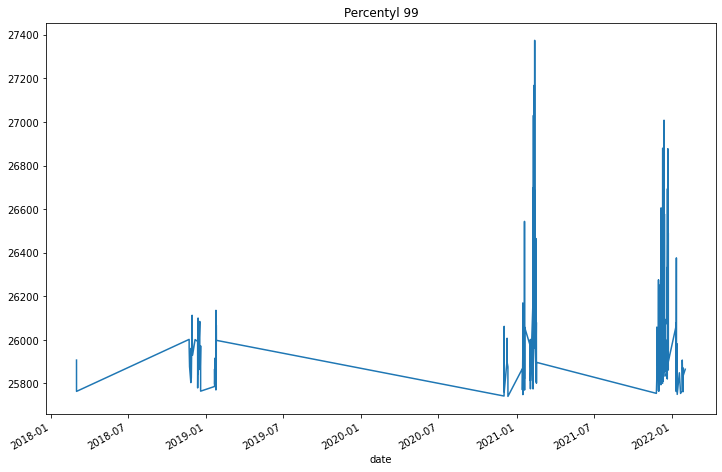

In [87]:
perc99 = np.percentile(train_prep.value, 99)
print( perc99 )
train_prep[ train_prep.value >= perc99]['value'].plot()
plt.title('Percentile 99');

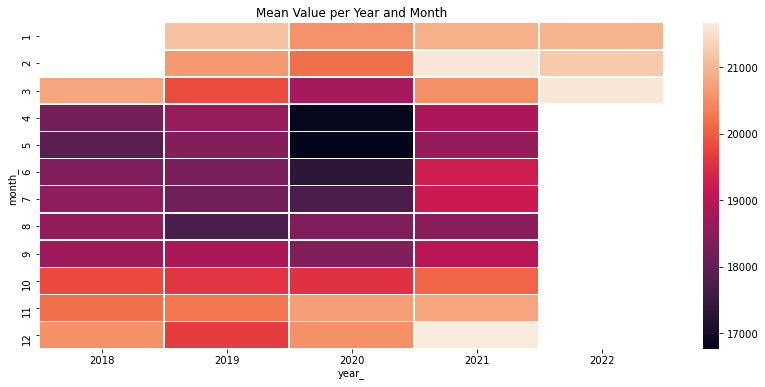

In [88]:
plt.figure(figsize=(14,6))
sns.heatmap(train_prep.groupby(['month_', 'year_']).aggregate('value').mean().reset_index().pivot('month_', 'year_', 'value'), linewidths=.5)
plt.title('Mean Value per Year and Month');

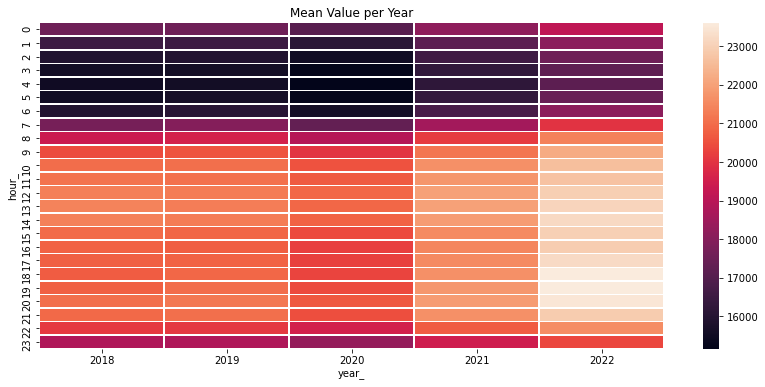

In [92]:
plt.figure(figsize=(14,6))
sns.heatmap(train_prep.groupby(['hour_', 'year_']).aggregate('value').mean().reset_index().pivot('hour_', 'year_', 'value'), linewidths=.5)
plt.title('Mean Value per Year');

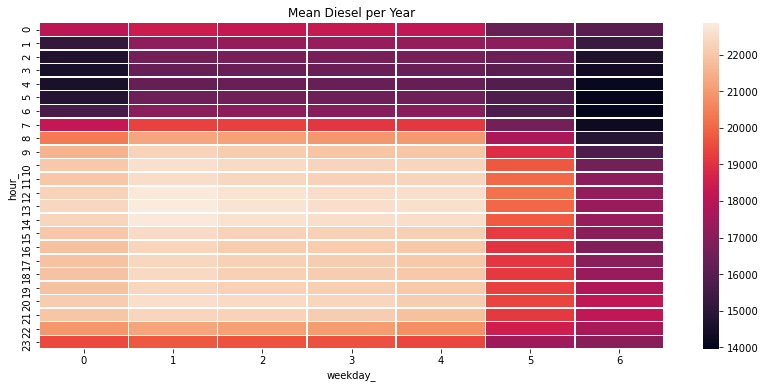

In [93]:
plt.figure(figsize=(14,6))
sns.heatmap(train_prep.groupby(['hour_', 'weekday_']).aggregate('value').mean().reset_index().pivot('hour_', 'weekday_', 'value'), linewidths=.5)
plt.title('Mean Diesel per Year');

In [164]:
feats = ['id', 'day_', 'weekday_', 'dayofweek', 'week_', 'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end', 'dayofyear', 'month_', 'year_', 'quarter_', 'hour_', 'isWeekend', 'is_year_start', 'is_year_end', 'taryfa_dzien', 'dark_hour', 'dark_hour_day', 'days', 'wakacje', 'week_in_month', 'trend', 'najwiekszy_przyrost_week', 'najwiekszy_przyrost_weekday', 'najwiekszy_spadek_weekday', 'najwiekszy_przyrost_hour', 'hour_5', 'hour_2', 'hour_4', 'hour_23', 'hour_0', 'hour_1', 'hour_3', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'czas_zimowy', 'holliday', 'boze_cialo', 'boze_nar', 'majowka', 'wigilia', 'szesciu_kroli', 'wielkanoc', 'swietych', 'zmiana_letnia', 'is_leap_year', '11_listopada', 'wielka_sobota']

In [39]:
xgb_params = {
        'max_depth': 9, 
        'n_estimators': 800,
        'learning_rate': 0.2, 
        'subsample': 0.5, 
        'random_state':0, 
        'colsample_bytree': 0.9
}

In [165]:
df_train=df_all_prep[df_all_prep["value"].notnull()].copy()
df_train.fillna(-1, inplace=True)
df_test=df_all_prep[df_all_prep["value"].isnull()].copy()
df_test.fillna(-1, inplace=True)

X_train=df_train[feats].values
y_train=df_train["value"].values
X_test=df_test[feats].values

## GroupKFold

In [166]:
cv = GroupKFold(n_splits=10)
model = xgb.XGBRegressor(**xgb_params)
scores = cross_val_score(model, X_train, y_train, groups=df_train["day_"], cv=cv, scoring="neg_mean_absolute_error")
np.mean(scores), np.std(scores)

(-330.9741718928978, 75.21618042104784)

In [148]:
cv = GroupKFold(n_splits=10)
model = xgb.XGBRegressor(**xgb_params)
scores = cross_val_score(model, X_train, y_train, groups=df_train["day_"], cv=cv, scoring="neg_mean_absolute_error")
np.mean(scores), np.std(scores)

(-336.7016885071951, 76.26696292591257)

In [167]:
model = xgb.XGBRegressor(**xgb_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [168]:
eli5.show_weights(model, feature_names=feats)

Weight,Feature
0.6426,dark_hour_day
0.1531,czas_zimowy
0.0658,holliday
0.0220,hour_23
0.0171,dayofweek
0.0149,wigilia
0.0098,is_year_start
0.0062,is_year_end
0.0059,hour_
0.0057,wielkanoc
